<h1>In this file we are processing the results of the population synthesis calculations with orbital evolution due to mass loss</h1>

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table, vstack
from astropy.io import fits
from scipy.integrate import solve_ivp
from scipy import interpolate
import time
# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

In [2]:
# reading in the results of the calculations:
hdul=fits.open('public_mybinaries_setup.fits')
full_binaries = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
print(len(full_binaries))
# we actually processed only the first 1e6 objects
nbinaries=1000000
mybinaries=full_binaries[0:nbinaries]
print(len(mybinaries))

ind0=(mybinaries['class']==0)
ind1=(mybinaries['class']==1)
ind2=(mybinaries['class']==2)
# OK, let's split the table into three:
temp0=Table(mybinaries[ind0], copy=True)
mybin1=Table(mybinaries[ind1], copy=True)
temp2=Table(mybinaries[ind2], copy=True)
# let's get this straight - how many of each class do we have?
print(len(temp0),len(mybin1),len(temp2))

# read the results of the calculations for WD-MS binaries and for WD-WD binaries:
hdul=fits.open('public_evolution_mybin0.fits')
mybin0=Table(hdul[1].data)
hdul.close()
hdul=fits.open('public_evolution_mybin2.fits')
mybin2=Table(hdul[1].data)
hdul.close()
print(len(mybin0),len(mybin1),len(mybin2))
ind_msms=(full_binaries['class']==1)
full_msms=full_binaries[ind_msms]
print('the full number of msms binaries ', len(full_msms))

# quadruple check that the same number for example is reported disrupted as in Step 1 and Step 2:
print('mybin0: total and disrupted (method1, 2): ', len( mybin0), len( mybin0[( mybin0['fsma']<0)]), len( mybin0[( mybin0['fecc']>1)]))
print('mybin2: total and disrupted (method1, 2): ', len( mybin2), len( mybin2[( mybin2['fsma2']<0)]), len( mybin2[( mybin2['fecc2']>1)]))



10000000
1000000
285640 679337 35023
285640 679337 35023
the full number of msms binaries  6787671
mybin0: total and disrupted (method1, 2):  285640 59480 59480
mybin2: total and disrupted (method1, 2):  35023 9132 9132


In [3]:
# let's read singles in:
hdul=fits.open('public_mysingles_setup.fits')
mysingles = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
nsingles=len(mysingles)
print(nsingles)

10000000


In [4]:
mysingles[0:5]

m,bday,death,class,fm
float64,float64,float64,float64,float64
1.9965623003369504,7.016165930806055,8.007647282722148,2.0,0.648724984026956
0.9441535960368855,0.9221055680967161,11.872612510114651,2.0,0.5645322876829508
0.4001252191377897,9.19033886204048,230.42425922819268,0.0,0.267746441818227
3.456001758244205,4.550360701312594,4.763893783154397,2.0,0.8302723287916662
0.4964725392696442,10.297716038550455,113.16389187951054,0.0,0.3322178895305547


In [5]:
present_day=12.0 # in Gyr
mybin0['age']=present_day-mybin0['bday']
mybin1['age']=present_day-mybin1['bday']
mybin2['age']=present_day-mybin2['bday']
mysingles['age']=present_day-mysingles['bday']

In [6]:
# inverting Cummings:
from scipy.interpolate import interp1d
def mfinal(minitial):
    # this is the initial-to-final relationship from Cummings et al. 2018
    # supplemented by constant fractional mass loss at M<0.83
    minitial=np.array([minitial])
    ind0=(minitial<=0.83)
    ind1=((minitial>0.83) & (minitial<=2.85))
    ind2=((minitial>2.85) & (minitial<=3.60))
    ind3=((minitial>3.60) & (minitial<=7.20))
    ind4=(minitial>7.20)
    mf=0.*minitial
    mf[ind0]=minitial[ind0]*(0.08*0.83+0.489)/0.83
    mf[ind1]=0.08*minitial[ind1]+0.489
    mf[ind2]=0.187*minitial[ind2]+0.184
    mf[ind3]=0.107*minitial[ind3]+0.471
    mf[ind4]=minitial[ind4]*(0.107*7.2+0.471)/7.2
    if (len(minitial)==1): 
        return(mf[0])
    else:
        return(mf)
minitial=np.arange(0.5,10.,0.1)
mf=mfinal(minitial)
invert_cummings = interp1d(mf, minitial, kind='cubic')


<h1>OK, let's make some statistics / fractions plots</h1>

In [7]:
# These are the defining variables for what we consider singles vs wide binaries
awide=1000.
alimit=1e4  # the wide binaries are those betwen awide and alimit
aclose=100. # this is the only variable that's necessary for defining effective singles

In [8]:
# let's identify objects that are effective singles
# from mybin1 all of the compact binaries:
ind0=(mybin1['sma']<aclose)
eff_singles0=Table([mybin1['m1'][ind0],np.full(len(mybin1[ind0]),0),mybin1['fm1'][ind0],mybin1['bday'][ind0]], names=('m', 'class', 'fm', 'bday'), copy=True)

# from full_msms all of the compact binaries:
ind0a=(full_msms['sma']<aclose)
full_msms_compact=Table(full_msms[ind0a], copy=True)

# In the MS-WD table, close binaries are singles with the surviving MS mass
ind1=((mybin0['fsma']<aclose) & (mybin0['fsma']>0))
eff_singles1=Table([mybin0['m2'][ind1],np.full(len(mybin0[ind1]),0),mybin0['fm2'][ind1],mybin0['bday'][ind1]], names=('m', 'class', 'fm', 'bday'), copy=True)

# disrupted binaries are singles:
ind2=(mybin0['fsma']<0)
# the more massive star is the WD
eff_singles2a=Table([mybin0['m1'][ind2],np.full(len(mybin0[ind2]),2),mybin0['fm1'][ind2],mybin0['bday'][ind2]], names=('m', 'class', 'fm', 'bday'), copy=True)
# the less massive star is MS
eff_singles2b=Table([mybin0['m2'][ind2],np.full(len(mybin0[ind2]),0),mybin0['fm2'][ind2],mybin0['bday'][ind2]], names=('m', 'class', 'fm', 'bday'), copy=True)

# In the WD-WD table, close binaries are singles with the lower WD mass
ind3=((mybin2['fsma2']<aclose) & (mybin2['fsma2']>0))
eff_singles3=Table([mybin2['m2'][ind3],np.full(len(mybin2[ind3]),2),mybin2['fm2'][ind3],mybin2['bday'][ind3]], names=('m', 'class', 'fm', 'bday'), copy=True)
# disrupted binaries are singles:
ind4=(mybin2['fsma2']<0)
eff_singles4a=Table([mybin2['m1'][ind4],np.full(len(mybin2[ind4]),2),mybin2['fm1'][ind4],mybin2['bday'][ind4]], names=('m', 'class', 'fm', 'bday'), copy=True)
eff_singles4b=Table([mybin2['m2'][ind4],np.full(len(mybin2[ind4]),2),mybin2['fm2'][ind4],mybin2['bday'][ind4]], names=('m', 'class', 'fm', 'bday'), copy=True)

eff_singles=vstack([eff_singles0, eff_singles1, eff_singles2a, eff_singles2b, eff_singles3, eff_singles4a, eff_singles4b])
print('total number of effective singles: ', len(eff_singles))
print('compact MS-MS binaries: ', len(eff_singles0), 'compact MS-WD binaries: ', len(eff_singles1), 
      '\nMS-WD binaries disrupted: ', len(eff_singles2a), len(eff_singles2b), 
      'compact WD-WD binaries: ', len(eff_singles3), 'WD-WD binaries disrupted: ', len(eff_singles4a), len(eff_singles4b))
eff_singles[0:5]

total number of effective singles:  736821
compact MS-MS binaries:  468294 compact MS-WD binaries:  118445 
MS-WD binaries disrupted:  59480 59480 compact WD-WD binaries:  12858 WD-WD binaries disrupted:  9132 9132


m,class,fm,bday
float64,int64,float64,float64
0.811124290920862,0,0.5427691941896949,8.898827774428966
0.5557201836875345,0,0.37186384339765866,9.526432723293606
0.6191791013149168,0,0.4143277986389215,9.995059677809007
0.774092656415268,0,0.5179892305699276,3.9785386334559845
0.5354437331449153,0,0.3582957221550434,4.404689614388227


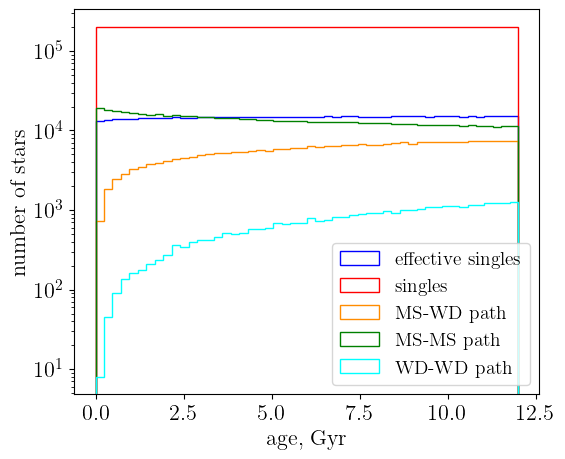

In [9]:
eff_singles['age']=present_day-eff_singles['bday']
# and just out of curiosity let's plot the distribution of ages
fig=plt.figure()
n_bins=50
(n, bins, patches)=plt.hist(eff_singles['age'], n_bins, histtype='step', stacked=True, fill=False, color='blue', label=r'effective singles')
plt.hist(mysingles['age'], bins, histtype='step', stacked=True, fill=False, color='red', label=r'singles')
plt.hist(mybin0['age'], bins, histtype='step', stacked=True, fill=False, color='darkorange', label=r'MS-WD path')
plt.hist(mybin1['age'], bins, histtype='step', stacked=True, fill=False, color='green', label=r'MS-MS path')
plt.hist(mybin2['age'], bins, histtype='step', stacked=True, fill=False, color='cyan', label=r'WD-WD path')
plt.yscale('log')
plt.xlabel(r'age, Gyr')
plt.ylabel('number of stars')
plt.legend(loc='lower right')
plt.show()

In [10]:
u=(eff_singles['class']==2)
print(len(eff_singles[u]))
# this agrees with the sum: MS-WD binaries disrupted + compact WD-WD binaries + 2*WD-WD binaries disrupted

90602


In [11]:
# just the wide binaries from each catalog
ind0=((mybin0['fsma']>=awide) & (mybin0['fsma']<alimit))
ind1=((mybin1['sma']>=awide) & (mybin1['sma']<alimit))
ind2=((mybin2['fsma2']>=awide) & (mybin2['fsma2']<alimit))
# MS-WD:
wbin0=Table(mybin0[ind0], copy=True)
# MS-MS:
wbin1=Table(mybin1[ind1], copy=True)
# WD-WD:
wbin2=Table(mybin2[ind2], copy=True)
wbinaries=len(wbin0)+len(wbin1)+len(wbin2)
print(wbinaries, nbinaries, len(wbin0), len(wbin1), len(wbin2))

# the large MS-MS catalog
ind_msms=((full_msms['sma']>=awide) & (full_msms['sma']<alimit))
full_msms_wbin=Table(full_msms[ind_msms], copy=True)
print('the large MS-MS catalog: full, just msms, compact, wide ', len(full_binaries), len(full_msms), len(full_msms_compact), len(full_msms_wbin))

85915 1000000 34027 47674 4214
the large MS-MS catalog: full, just msms, compact, wide  10000000 6787671 4681266 472275


In [12]:
# this is a parameter of the model: the overall fraction of the wide binary stars in the population
fbinaries=0.02 # this has been revised down so that the results agree more or less with observations
# maybe let's say for the purposes of the normalization that it's the main sequence binary fraction!
# then fbinaries should be equal to number of MS stars in binaries / number of all MS stars in the survey:
# fbinaries=(len(wbin0)+2*len(wbin1))/(len(mybin0)+2*len(mybin1)-len(eff_singles0)+single_norm*number of MS singles)
number_ms_singles=len(mysingles[(mysingles['class']==0.)])
print(number_ms_singles)
single_norm=((len(wbin0)+2*len(wbin1))/fbinaries-(len(mybin0)+2*len(mybin1)-len(eff_singles0)))/number_ms_singles
#single_norm=(2*wbinaries/fbinaries-len(eff_singles))/nsingles
print(nbinaries, nsingles, single_norm)
# so this is somehow a little different from the MS-MS value we calculated in the setup file, but I am actually 
# going to go with that value instead

# single_norm will be the value for iteration.
# best_norm is the value we have chosen
single_norm=0.4
best_norm=0.4
try_norm=[0.15, 0.4, 1.5]

8219822
1000000 10000000 0.6438983715219138


In [13]:
# this is from the input file
mmin=0.3
mbreak=0.5
#mmax=7.2
mmax=9.0
alpha1=-1.3
alpha2=-2.3

In [14]:
def mass_ms(bprp):
    return(1.9577-1.4539*bprp+0.4208*bprp**2+0.0281*bprp**3-0.0344*bprp**4+0.0042*bprp**5)
print(mass_ms(0.8),mass_ms(2.826))

1.065565216 0.40677046927771576


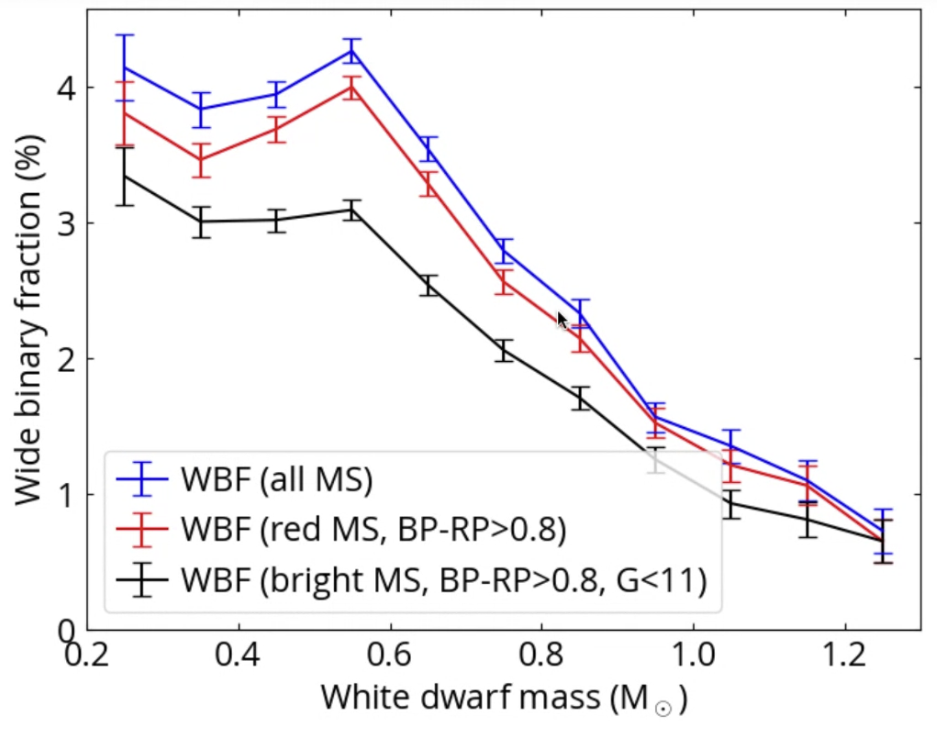

In [15]:
# reading data off the graph from Hsiang-Chih's dynamics plots:
m_red=1.066 # this is the mass that corresponds to BP-RP>0.8 cut
m_bright=0.407 # G<11 corresponds to BP-RP<2.826
# this is the plot from Hsiang-Chih for WD binary fraction as a function of mass. 
# His wide binaries are defined to be between 1e3 and 1e4
from IPython.display import Image
Image(filename='hchwang_july_2_WDBF.png', width=500)


i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  0 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  1 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  2 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  3 9319.0 9248.0 6101.0 472039.0 18452.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  4 16323.0 15845.0 10630.0 774142.0 34475.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  5 3048.0 2917.0 1974.0 165768.0 9322.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  6 1914.0 1808.0 1227.0 113089.0 7125.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  7 1377.0 1308.0 884.0 93387.0 6787.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  8 848.0 796.0 572.0 60362.0 4905.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  9 498.0 475.0 326.0 41583.0 3726.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  10 284.0 265.0 182.0 24545.0

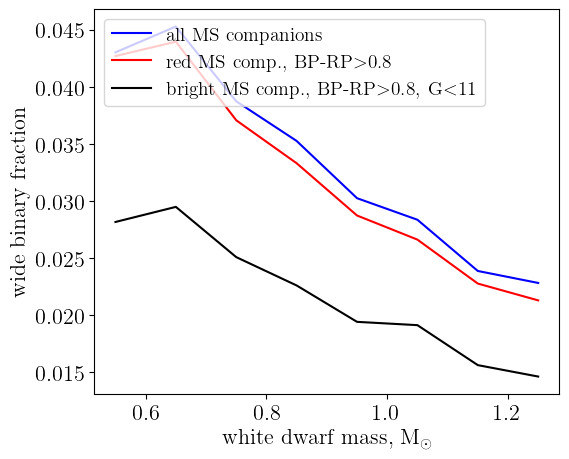

In [16]:
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
for i,mass in enumerate(wd_bins):
    # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
    # is in the right range
    ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
    wdf[i]=len(mybin0[ind0])
    # now also add the criterion on the MS companion:
    ind0_red=(ind0 & (mybin0['m2']<m_red))
    wdf_red[i]=len(mybin0[ind0_red])
    # now also add the criterion that it should be bright:
    ind0_bright=(ind0_red & (mybin0['m2']>m_bright))
    wdf_bright[i]=len(mybin0[ind0_bright])
    
    # now let's look at the corresponding singles:
    ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])
    
    # now let's look at the effective singles:
    ind2=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind2])
    
    # numbers in each category:
    print('i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single: ', i, wdf[i], 
          wdf_red[i], wdf_bright[i], wdf_single[i], wdf_eff_single[i])

temp=(wdf_single>0)
wdf_fraction=wdf[temp]/(wdf[temp]+wdf_eff_single[temp]+best_norm*wdf_single[temp])    
wdf_fraction_red=wdf_red[temp]/(wdf[temp]+wdf_eff_single[temp]+best_norm*wdf_single[temp])    
wdf_fraction_bright=wdf_bright[temp]/(wdf[temp]+wdf_eff_single[temp]+best_norm*wdf_single[temp])   

fig=plt.figure()
plt.plot(wd_bins[temp],wdf_fraction,color='blue',label='all MS companions')
plt.plot(wd_bins[temp],wdf_fraction_red,color='red',label=r'red MS comp., BP-RP$>$0.8')
plt.plot(wd_bins[temp],wdf_fraction_bright,color='black',label=r'bright MS comp., BP-RP$>$0.8, G$<$11')
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('wide binary fraction')
plt.legend(loc='upper left')
plt.show()

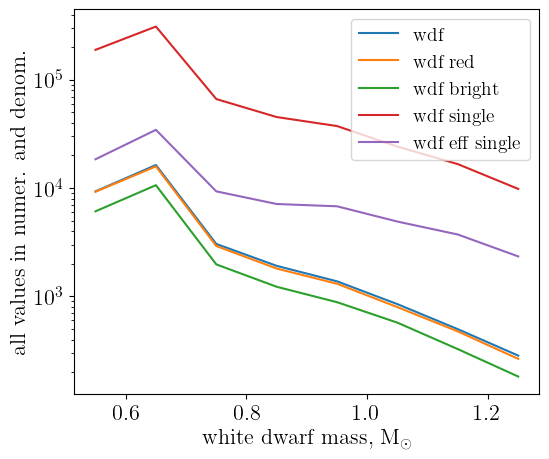

In [17]:
plt.figure()
plt.plot(wd_bins[temp], wdf[temp],label='wdf')
plt.plot(wd_bins[temp], wdf_red[temp],label='wdf red')
plt.plot(wd_bins[temp], wdf_bright[temp],label='wdf bright')
plt.plot(wd_bins[temp], best_norm*wdf_single[temp],label='wdf single')
plt.plot(wd_bins[temp], wdf_eff_single[temp],label='wdf eff single')
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('all values in numer. and denom.')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

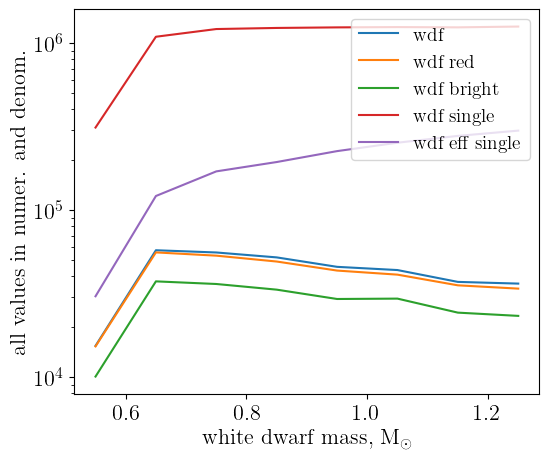

In [18]:
# OK, something is weird. Which one in the denominator is declining too fast?
ms_bins=invert_cummings(wd_bins[temp])
ms_bins_lo=invert_cummings(wd_bins_lo[temp])
ms_bins_hi=invert_cummings(wd_bins_hi[temp])
# at these ms masses, all masses for singles are drawn from the same powerlaw, so let's normalize to that:
int_kroupa=np.zeros(len(ms_bins))
for i,mass in enumerate(ms_bins):
    int_kroupa[i]=(ms_bins_hi[i]**(alpha2+1)-ms_bins_lo[i]**(alpha2+1))/(alpha2+1)
plt.figure()
plt.plot(wd_bins[temp], wdf[temp]/int_kroupa,label='wdf')
plt.plot(wd_bins[temp], wdf_red[temp]/int_kroupa,label='wdf red')
plt.plot(wd_bins[temp], wdf_bright[temp]/int_kroupa,label='wdf bright')
plt.plot(wd_bins[temp], best_norm*wdf_single[temp]/int_kroupa,label='wdf single')
plt.plot(wd_bins[temp], wdf_eff_single[temp]/int_kroupa,label='wdf eff single')
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('all values in numer. and denom.')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()
# I understand the edge effects. On the low-mass end, not all objects have time to evolve off the MS. 
# on the high-mass end, the original model only extends to 7.0, so the kroupa normalization is over-estimated
# and the number of objects is under-estimated. This could probably be fixed by initiating the initial model with 
# masses up to 10, but doing statistics only to 1.3 in WD mass. 
# in order for the WD binary fraction to drop by a factor of 7, either the numbers relative to the Kroupa 
# need to drop by a factor of 7 of the denominator needs to increase by a factor of 7, and neither 
# of these things is happening... 

i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  0 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  1 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  2 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  3 9319.0 9248.0 6101.0 472039.0 18452.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  4 16323.0 15845.0 10630.0 774142.0 34475.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  5 3048.0 2917.0 1974.0 165768.0 9322.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  6 1914.0 1808.0 1227.0 113089.0 7125.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  7 1377.0 1308.0 884.0 93387.0 6787.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  8 848.0 796.0 572.0 60362.0 4905.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  9 498.0 475.0 326.0 41583.0 3726.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  10 284.0 265.0 182.0 24545.0

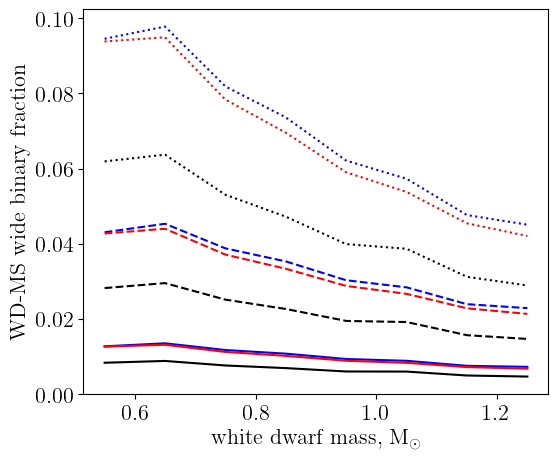

In [19]:
fig=plt.figure()
mystyles=['dotted', 'dashed', 'solid']

wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
for i,mass in enumerate(wd_bins):
    # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
    # is in the right range
    ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
    wdf[i]=len(mybin0[ind0])
    # now also add the criterion on the MS companion:
    ind0_red=(ind0 & (mybin0['m2']<m_red))
    wdf_red[i]=len(mybin0[ind0_red])
    # now also add the criterion that it should be bright:
    ind0_bright=(ind0_red & (mybin0['m2']>m_bright))
    wdf_bright[i]=len(mybin0[ind0_bright])

    # now let's look at the corresponding singles:
    ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])

    # now let's look at the effective singles:
    ind2=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind2])
    # so... this is not quite accurate. White dwarfs in MS-WD pairs but at wrong separations would also count
    # in the denominator, and so would WD-WD pairs which are not effective singles
    # and even though we don't really think this should matter, it would be really nice to include everything 
    # correctly, or at least explore how much this would matter... 

    # numbers in each category:
    print('i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single: ', i, wdf[i], 
          wdf_red[i], wdf_bright[i], wdf_single[i], wdf_eff_single[i])

temp=(wdf_single>0)
for j,single_norm in enumerate(try_norm):
    wdf_fraction=wdf[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_red=wdf_red[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_bright=wdf_bright[temp]/(wdf[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])   

    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    plt.plot(wd_bins[temp],wdf_fraction_red,color='red',linestyle=mystyles[j],label='WDF (red MS, BP-RP>0.8)')
    plt.plot(wd_bins[temp],wdf_fraction_bright,color='black',linestyle=mystyles[j],label='WDF (bright MS, BP-RP>0.8, G<11)')
    
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-MS wide binary fraction')
plt.show()

In [20]:
def err_frac(x1,x2,x3,single_norm):
    dfdx1=1./(x2+single_norm*x3)
    dfdx2=x1/(x2+single_norm*x3)**2
    dfdx3=single_norm*x1/(x2+single_norm*x3)**2
    return(np.sqrt(dfdx1**2*x1+dfdx2**2*x2+dfdx3**2*x3))

i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  0 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  1 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  2 0.0 0.0 0.0 0.0 0.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  3 9319.0 9248.0 6101.0 472039.0 18452.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  4 16323.0 15845.0 10630.0 774142.0 34475.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  5 3048.0 2917.0 1974.0 165768.0 9322.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  6 1914.0 1808.0 1227.0 113089.0 7125.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  7 1377.0 1308.0 884.0 93387.0 6787.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  8 848.0 796.0 572.0 60362.0 4905.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  9 498.0 475.0 326.0 41583.0 3726.0
i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single:  10 284.0 265.0 182.0 24545.0

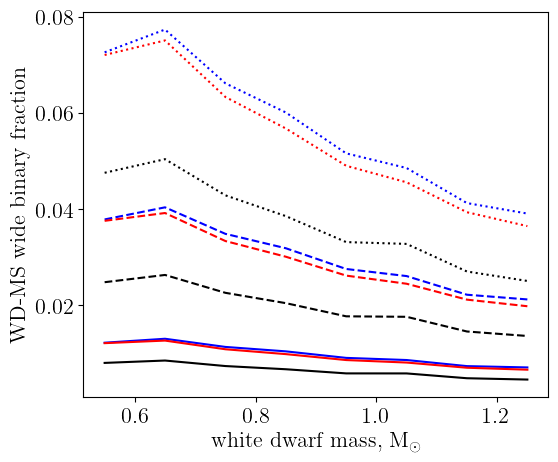

In [21]:
# OK, let's try again and see whether properly counting objects in the denominator makes a huge amount of difference
fig=plt.figure()
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single, wdf_other=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
err, err_red, err_bright=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
for i,mass in enumerate(wd_bins):
    # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
    # is in the right range
    ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
    wdf[i]=len(mybin0[ind0])
    # now also add the criterion on the MS companion:
    ind0_red=(ind0 & (mybin0['m2']<m_red))
    wdf_red[i]=len(mybin0[ind0_red])
    # now also add the criterion that it should be bright:
    ind0_bright=(ind0_red & (mybin0['m2']>m_bright))
    wdf_bright[i]=len(mybin0[ind0_bright])

    # now let's look at the corresponding singles:
    ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])

    # now let's look at the effective singles:
    ind2=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind2])

    # OK, if the WD is in the right mass range but in the wrong separation range, if it's not too close to the 
    # MS star, then it will be in the denominator. Let's take the max possible value here because it will make
    # the max possible difference with the previous plot, and then we'll know what the uncertainty is.
    # Because it's not really clear whether in a survey the binaries that are between 100 and 1000 AU are 
    # going to be resolved; here we are considering the largest-denominator scenario that they are
    ind0a=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>aclose))
    # but if they are in the right regime of separations, they have already been counted above... so we should
    # remove the original count from the denominator!! 
    # and the same for the WD-WD binaries (effective singles have already been counted, so we only need to
    # count bound WD-WD binaries at the wrong separations)
    ind2a=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
    ind2b=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
    # sum them up:
    wdf_other[i]=len(mybin0[ind0a])+len(mybin2[ind2a])+len(mybin2[ind2b])
    # numbers in each category:
    print('i, wdf, wdf_red, wdf_bright, wdf_single, wdf_eff_single: ', i, wdf[i], 
          wdf_red[i], wdf_bright[i], wdf_single[i], wdf_eff_single[i])

temp=(wdf_single>0)
for j,single_norm in enumerate(try_norm):
    wdf_fraction=wdf[temp]/(wdf_eff_single[temp]+wdf_other[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_red=wdf_red[temp]/(wdf_eff_single[temp]+wdf_other[temp]+single_norm*wdf_single[temp])    
    wdf_fraction_bright=wdf_bright[temp]/(wdf_eff_single[temp]+wdf_other[temp]+single_norm*wdf_single[temp]) 
    err=err_frac(wdf[temp],wdf_eff_single[temp]+wdf_other[temp],wdf_single[temp],single_norm)
    err_red=err_frac(wdf_red[temp],wdf_eff_single[temp]+wdf_other[temp],wdf_single[temp],single_norm)
    err_bright=err_frac(wdf_bright[temp],wdf_eff_single[temp]+wdf_other[temp],wdf_single[temp],single_norm)

    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    plt.plot(wd_bins[temp],wdf_fraction_red,color='red',linestyle=mystyles[j],label='WDF (red MS, BP-RP>0.8)')
    plt.plot(wd_bins[temp],wdf_fraction_bright,color='black',linestyle=mystyles[j],label='WDF (bright MS, BP-RP>0.8, G<11)')
    
    if (j==1):
        print('I am here')
        wdms=Table()
        wdms['wd_bins']=wd_bins[temp]
        wdms['frac']=wdf_fraction
        wdms['frac_red']=wdf_fraction_red
        wdms['frac_bright']=wdf_fraction_bright
        wdms['err']=err
        wdms['err_red']=err_red
        wdms['err_bright']=err_bright
    
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-MS wide binary fraction')
plt.show()
# OK, so there is a slight reduction in the fraction, as expected, but qualitatively the behavior doesn't change,
# and any intermediate ways of counting would be in between these curves and the previous curves, because we
# basically said that all objects above 100 AU are individually resolvable and count in the denominator, which
# I don't think is true. 

In [22]:
wdms

wd_bins,frac,frac_red,frac_bright,err,err_red,err_bright
float64,float64,float64,float64,float64,float64,float64
0.5499999999999999,0.037827586738790345,0.037539384285903324,0.024765115000897082,0.0003958366765338423,0.0003942958058985236,0.00031917235119240556
0.6499999999999999,0.04034596236354226,0.03916447795444018,0.02627443361664242,0.0003192175965224212,0.0003144105695351741,0.00025664353435894785
0.7499999999999999,0.034827439634723234,0.03333059101525186,0.02255556622012587,0.0006367957462272018,0.0006227114383800221,0.0005107815723435422
0.8499999999999999,0.031833362161874476,0.0300703859919901,0.02040728075894461,0.0007339575595348498,0.0007130051831525176,0.0005858418056392533
0.9499999999999998,0.027515896075038265,0.026137103896986237,0.017664525875333206,0.0007471209021355549,0.0007278885567351576,0.0005970125647994953
1.0499999999999998,0.02604118683937378,0.024444321608657463,0.017565517537879483,0.000900698561518568,0.0008722645957089994,0.0007380233239941543
1.15,0.022158742024187734,0.021135346308211192,0.014505521887319682,0.000999054323535173,0.0009754368565408024,0.0008066193771950982
1.2499999999999998,0.021179804608844804,0.019762845849802372,0.013572973376090685,0.0012642304499108682,0.0012207295431378878,0.0010099167313894727


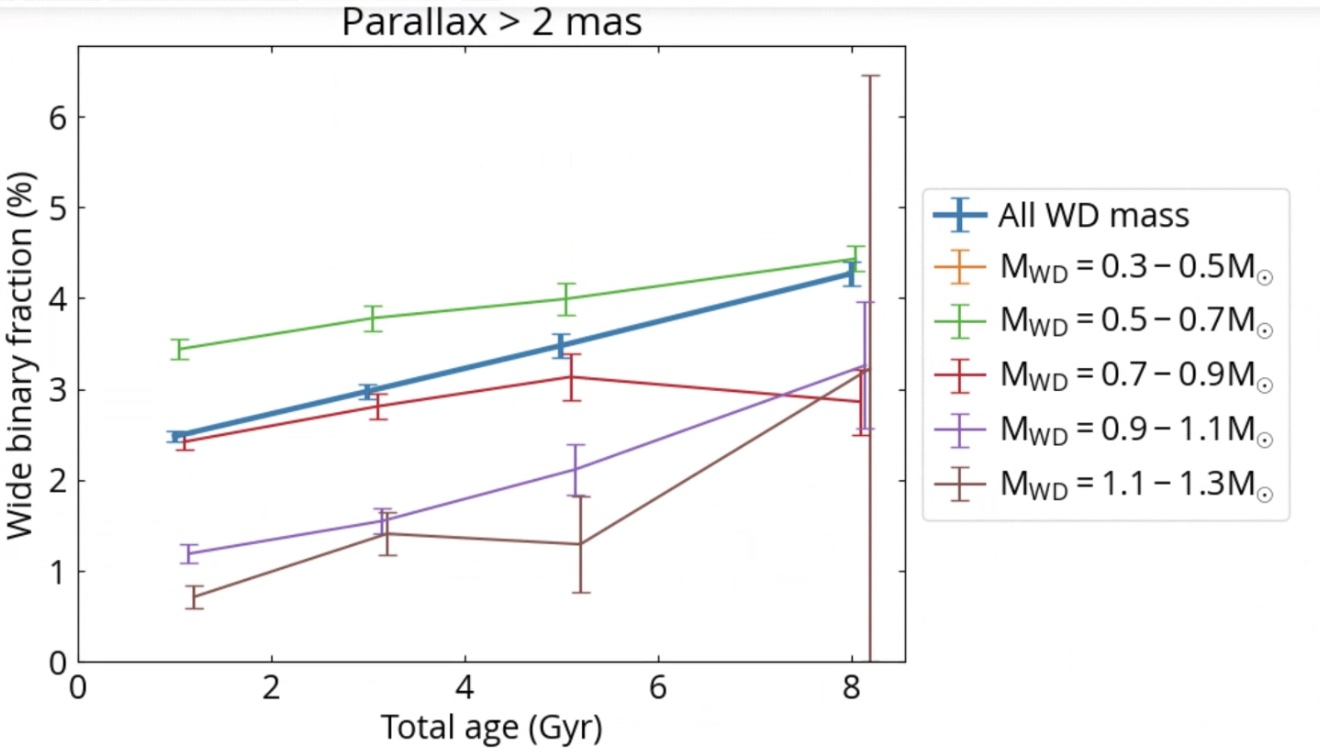

In [23]:
Image(filename='hchwang_july_2_WDBF_age.jpg', width=500)


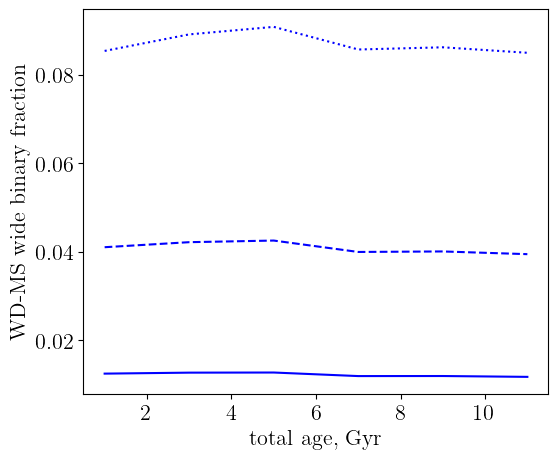

In [24]:
# OK, let's look as a function of age:
fig=plt.figure()
age_bins=np.arange(1,13,2)
age_bins_lo=age_bins-1.
age_bins_hi=age_bins+1.
wdf, wdf_single, wdf_eff_single=np.zeros(len(age_bins)), np.zeros(len(age_bins)), np.zeros(len(age_bins))
for i,age in enumerate(age_bins):
    # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
    # is in the right range
    ind0=((mybin0['age']>=age_bins_lo[i]) & (mybin0['age']<age_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
    wdf[i]=len(mybin0[ind0])

    # now let's look at the corresponding singles:
    ind1=((mysingles['age']>=age_bins_lo[i]) & (mysingles['age']<age_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])
    if (wdf_single[i]==0):
        print('age=', age, ' best_norm=', best_norm)

    # now let's look at the effective singles:
    ind2=((eff_singles['age']>=age_bins_lo[i]) & (eff_singles['age']<age_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind2])

for j,single_norm in enumerate(try_norm):
    wdf_fraction=wdf/(wdf+wdf_eff_single+single_norm*wdf_single)    
    plt.plot(age_bins,wdf_fraction,linestyle=mystyles[j],color='blue')
plt.xlabel('total age, Gyr')
plt.ylabel('WD-MS wide binary fraction')
plt.show()

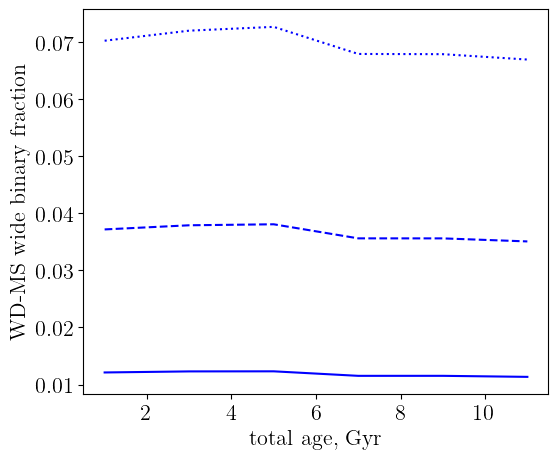

In [25]:
# Amend the previous plot with a better calculation of the denominator: 
fig=plt.figure()
age_bins=np.arange(1,13,2)
age_bins_lo=age_bins-1.
age_bins_hi=age_bins+1.
wdf, wdf_single, wdf_other, wdf_eff_single=np.zeros(len(age_bins)), np.zeros(len(age_bins)), np.zeros(len(age_bins)), np.zeros(len(age_bins))
for i,age in enumerate(age_bins):
    # OK, we are looking at WD-MS binaries and the mass is in the right bin and the separation
    # is in the right range
    ind0=((mybin0['age']>=age_bins_lo[i]) & (mybin0['age']<age_bins_hi[i]) & (mybin0['fsma']>awide) & (mybin0['fsma']<alimit))
    wdf[i]=len(mybin0[ind0])

    # now let's look at the corresponding singles:
    ind1=((mysingles['age']>=age_bins_lo[i]) & (mysingles['age']<age_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])
    if (wdf_single[i]==0):
        print('age=', age, ' best_norm=', best_norm)

    # now let's look at the effective singles:
    ind2=((eff_singles['age']>=age_bins_lo[i]) & (eff_singles['age']<age_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind2])

    # now let's look at the binaries at all separations:
    ind0a=((mybin0['age']>=age_bins_lo[i]) & (mybin0['age']<age_bins_hi[i]) & (mybin0['fsma']>aclose))
    ind2a=((mybin2['age']>=age_bins_lo[i]) & (mybin2['age']<age_bins_hi[i]) & (mybin2['fsma2']>aclose))
    # count them up
    wdf_other[i]=len(mybin0[ind0a])+2*len(mybin2[ind2a])
    # and these ones already include all of the WD-MS binaries at the correct separation, so no need to include
    # wdf in the denominator:
    
for j,single_norm in enumerate(try_norm):
    wdf_fraction=wdf/(wdf_other+wdf_eff_single+single_norm*wdf_single)    
    plt.plot(age_bins,wdf_fraction,linestyle=mystyles[j],color='blue')
plt.xlabel('total age, Gyr')
plt.ylabel('WD-MS wide binary fraction')
plt.show()
# also slightly lower, as expected, but no change in qualitative behavior... 

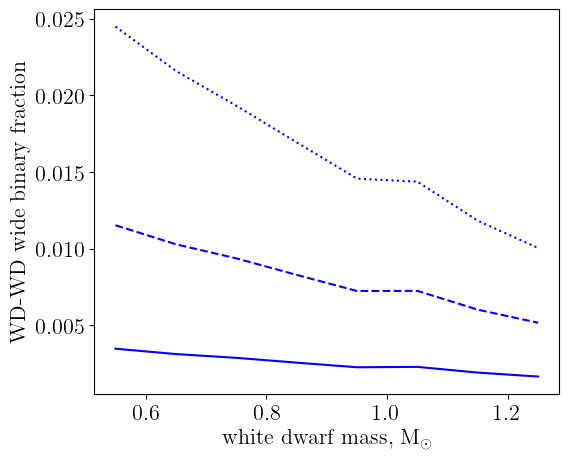

In [26]:
# OK, one more thing is the WD-WD wide binary fraction as a function of mass... 
# let's do a "minimum" denominator calculation first: 
fig=plt.figure()
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
wdf, wdf_other, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
for i,mass in enumerate(wd_bins):
    # OK, we are looking at WD-WD binaries and the mass is in the right bin and the separation
    # is in the right range
    ind2a=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
    ind2b=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
    wdf[i]=len(mybin2[ind2a])+len(mybin2[ind2b])

    # now let's look at the corresponding singles:
    ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])

    # now let's look at the effective singles:
    ind3=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind3])

    # there are no white dwarfs in the mybin1 table
    # count up the white dwarfs in the mybin0 table, but only if they are well spatially resolved from the MS star:
    ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>awide))
    wdf_other[i]=len(mybin0[ind0])

temp=(wdf_single>0)

for j,single_norm in enumerate(try_norm):
    wdf_fraction=wdf[temp]/(wdf[temp]+wdf_other[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    

    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    
plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-WD wide binary fraction')
plt.show()

i, wdf, wdf_single, wdf_eff_single, wdf_other:  0 0.0 0.0 0.0 0.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  1 0.0 0.0 0.0 0.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  2 0.0 0.0 0.0 0.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  3 2567.0 472039.0 18452.0 39087.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  4 3796.0 774142.0 34475.0 60444.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  5 752.0 165768.0 9322.0 11888.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  6 458.0 113089.0 7125.0 7765.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  7 335.0 93387.0 6787.0 5902.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  8 220.0 60362.0 4905.0 3514.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  9 127.0 41583.0 3726.0 2115.0
i, wdf, wdf_single, wdf_eff_single, wdf_other:  10 65.0 24545.0 2339.0 1252.0


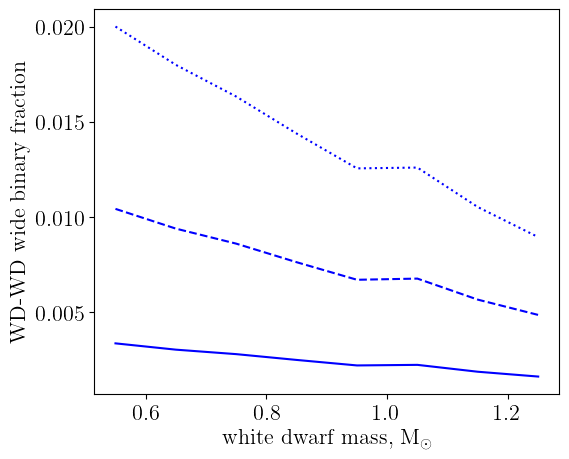

In [27]:
# same, but maximize the denominator and see how much difference this makes:
# include MS-WD binaries that are poorly resolved and WD-WD binaries at all separations
fig=plt.figure()
wd_bins=np.arange(0.25,1.35,0.1)
wd_bins_lo=np.arange(0.2,1.3,0.1)
wd_bins_hi=np.arange(0.3,1.4,0.1)
wdf, wdf_other, wdf_single, wdf_eff_single=np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins)), np.zeros(len(wd_bins))
for i,mass in enumerate(wd_bins):
    # OK, we are looking at WD-WD binaries and the mass is in the right bin and the separation
    # is in the right range
    ind2a=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
    ind2b=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>awide) & (mybin2['fsma2']<alimit))
    wdf[i]=len(mybin2[ind2a])+len(mybin2[ind2b])

    # now let's look at the corresponding singles:
    ind1=((mysingles['fm']>=wd_bins_lo[i]) & (mysingles['fm']<wd_bins_hi[i]) & (mysingles['class']==2))
    wdf_single[i]=len(mysingles[ind1])

    # now let's look at the effective singles:
    ind3=((eff_singles['fm']>=wd_bins_lo[i]) & (eff_singles['fm']<wd_bins_hi[i]) & (eff_singles['class']==2))
    wdf_eff_single[i]=len(eff_singles[ind3])

    # there are no white dwarfs in the mybin1 table
    # count up the white dwarfs in the mybin0 table, but only if they are not in effective singles: 
    ind0=((mybin0['fm1']>=wd_bins_lo[i]) & (mybin0['fm1']<wd_bins_hi[i]) & (mybin0['fsma']>aclose))
    # count up the white dwarfs in the mybin2 table at all separations: 
    ind2c=((mybin2['fm1']>=wd_bins_lo[i]) & (mybin2['fm1']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
    ind2d=((mybin2['fm2']>=wd_bins_lo[i]) & (mybin2['fm2']<wd_bins_hi[i]) & (mybin2['fsma2']>aclose))
    wdf_other[i]=len(mybin0[ind0])+len(mybin2[ind2c])+len(mybin2[ind2d])

    print('i, wdf, wdf_single, wdf_eff_single, wdf_other: ', i, wdf[i], wdf_single[i], wdf_eff_single[i], wdf_other[i])

temp=(wdf_single>0)

for j,single_norm in enumerate(try_norm):
    wdf_fraction=wdf[temp]/(wdf_other[temp]+wdf_eff_single[temp]+single_norm*wdf_single[temp])    
    
    plt.plot(wd_bins[temp],wdf_fraction,color='blue',linestyle=mystyles[j],label='WDF (all MS)')
    
    if (j==1):
        wdwd=Table()
        wdwd['wd_bins']=wd_bins[temp]
        wdwd['frac']=wdf_fraction
        wdwd['err']=err_frac(wdf[temp],wdf_other[temp]+wdf_eff_single[temp],wdf_single[temp],single_norm)

plt.xlabel(r'white dwarf mass, M$_{\odot}$')
plt.ylabel('WD-WD wide binary fraction')
plt.show()

<h1>Show MS-MS, MS-WD and WD-WD binary fractions on the same plot and calculate the retention fraction</h1>

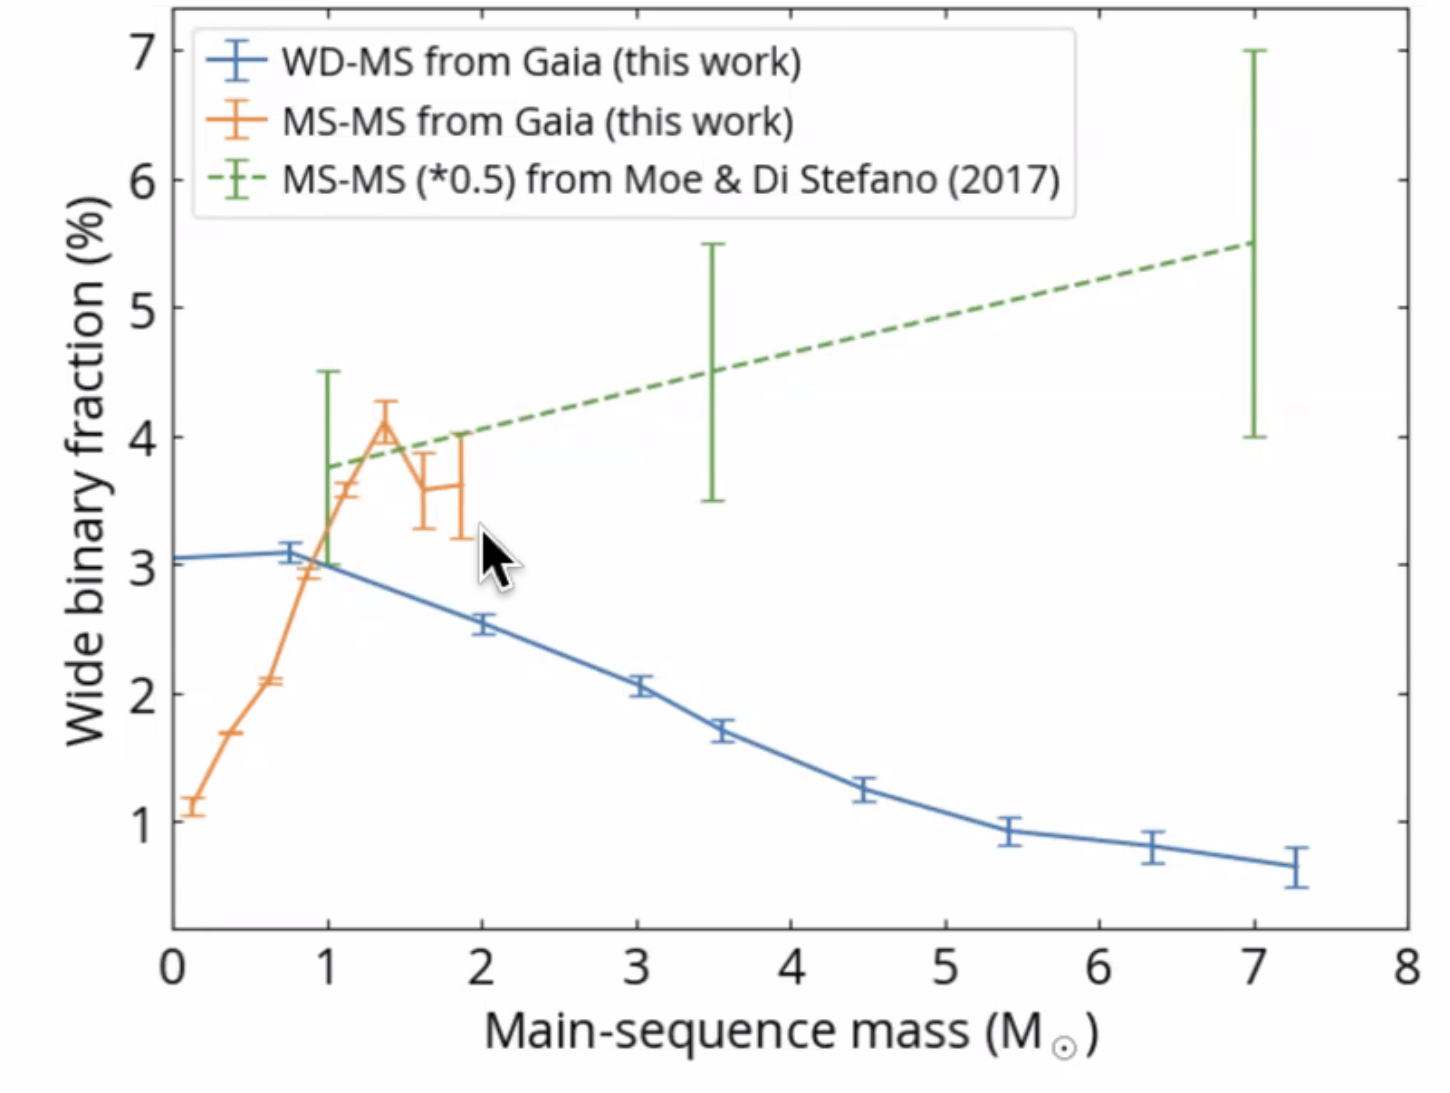

In [28]:
Image(filename='hchwang_july_17_MS_vs_WD.png', width=500)
# this plot is made WITH CONSTRAINTS ON THE COMPANION (color and brightness)

In [29]:
wd_bins=wdms['wd_bins']
delta_bins=0.5*(wd_bins[1]-wd_bins[0])
wd_bins_lo=wd_bins-delta_bins
wd_bins_hi=wd_bins+delta_bins
ms_bins=invert_cummings(wd_bins)
ms_bins_lo=invert_cummings(wd_bins_lo)
ms_bins_hi=invert_cummings(wd_bins_hi)
# set up vectors for all values defaulting to -1 to catch any bins where we don't have any objects,
# although I think I removed the problematic low-mass bins already
msms, msms_red, msms_bright, msms_single, msms_other = np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1.


In [30]:
print(single_norm,best_norm)

1.5 0.4


i, msms, msms_red, msms_bright:  0 35640.0 33525.0 22448.0
i, msms, msms_red, msms_bright:  1 3188.0 2726.0 1831.0
i, msms, msms_red, msms_bright:  2 159.0 131.0 96.0
i, msms, msms_red, msms_bright:  3 60.0 51.0 37.0
i, msms, msms_red, msms_bright:  4 34.0 29.0 19.0
i, msms, msms_red, msms_bright:  5 13.0 11.0 7.0
i, msms, msms_red, msms_bright:  6 4.0 2.0 1.0
i, msms, msms_red, msms_bright:  7 2.0 2.0 1.0


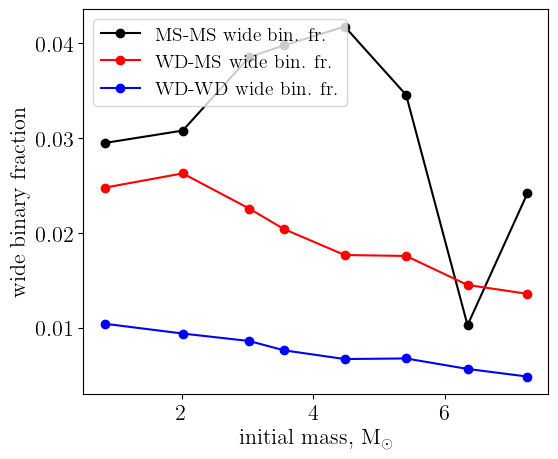

In [31]:
for i,mass in enumerate(ms_bins):
    # MS-MS wide-binary fraction: only mybin0 and mybin1 matter
    # numerator
    ind1a=((mybin1['sma']>awide) & (mybin1['sma']<alimit) & (mybin1['m1']>=ms_bins_lo[i]) & (mybin1['m1']<ms_bins_hi[i]))
    ind1b=((mybin1['sma']>awide) & (mybin1['sma']<alimit) & (mybin1['m2']>=ms_bins_lo[i]) & (mybin1['m2']<ms_bins_hi[i]))
    msms[i]=len(mybin1[ind1a])+len(mybin1[ind1b])
    # now also add the red criterion on the MS companion:
    ind1c=(ind1a & (mybin1['m2']<m_red))
    ind1d=(ind1b & (mybin1['m1']<m_red))
    msms_red[i]=len(mybin1[ind1c])+len(mybin1[ind1d])
    # now also add the bright criterion on the MS companion:
    ind1e=(ind1c & (mybin1['m2']>m_bright))
    ind1f=(ind1d & (mybin1['m1']>m_bright))
    msms_bright[i]=len(mybin1[ind1e])+len(mybin1[ind1f])
    print('i, msms, msms_red, msms_bright: ', i, msms[i], msms_red[i], msms_bright[i])
    
    # denominator: all of the MS from WD-MS pairs count
    ind0=((mybin0['m2']>=ms_bins_lo[i]) & (mybin0['m2']<ms_bins_hi[i]))
    # effective singles have to be computed specially. Nothing comes from mybin2. 
    # Mybin0 is already fully taken into account at all separations. We need to consider mybin1, either close binaries
    # or those that are not in close binaries but are not in wide binaries either.
    # for close binaries, it's the more massive star 1 that should be in the mass range:
    eff1=((mybin1['sma']<aclose) & (mybin1['m1']>=ms_bins_lo[i]) & (mybin1['m1']<ms_bins_hi[i]))
    # for all other binaries: 
#    eff1a=((mybin1['sma']>aclose) & (mybin1['m1']>=ms_bins_lo[i]) & (mybin1['m1']<ms_bins_hi[i]))
#    eff1b=((mybin1['sma']>aclose) & (mybin1['m2']>=ms_bins_lo[i]) & (mybin1['m2']<ms_bins_hi[i]))
#    msms_other[i]=len(mybin0[ind0])+len(mybin1[eff1])+len(mybin1[eff1a])+len(mybin1[eff1b])
    msms_other[i]=len(mybin0[ind0])+len(mybin1[eff1])
    
    # singles
    inds=((mysingles['m']>=ms_bins_lo[i]) & (mysingles['m']<ms_bins_hi[i]) & (mysingles['class']==0))
    msms_single[i]=len(mysingles[inds])
    
        
msms_fraction=msms/(msms+msms_other+best_norm*msms_single)
msms_fraction_red=msms_red/(msms+msms_other+best_norm*msms_single)
msms_fraction_bright=msms_bright/(msms+msms_other+best_norm*msms_single)

plt.plot(ms_bins, msms_fraction_bright, color='black', marker='o', label='MS-MS wide bin. fr.')                                  
plt.plot(ms_bins, wdms['frac_bright'],color='red', marker='o', label='WD-MS wide bin. fr.')                                  
plt.plot(ms_bins, wdwd['frac'],color='blue', marker='o', label='WD-WD wide bin. fr.')                                  
plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('wide binary fraction')
plt.legend(loc='upper left')
plt.show()

i, msms, msms_red, msms_bright:  0 353799.0 332170.0 223561.0
i, msms, msms_red, msms_bright:  1 31749.0 27072.0 18206.0
i, msms, msms_red, msms_bright:  2 1547.0 1254.0 864.0
i, msms, msms_red, msms_bright:  3 587.0 474.0 345.0
i, msms, msms_red, msms_bright:  4 309.0 263.0 181.0
i, msms, msms_red, msms_bright:  5 135.0 98.0 71.0
i, msms, msms_red, msms_bright:  6 49.0 41.0 27.0
i, msms, msms_red, msms_bright:  7 25.0 19.0 15.0


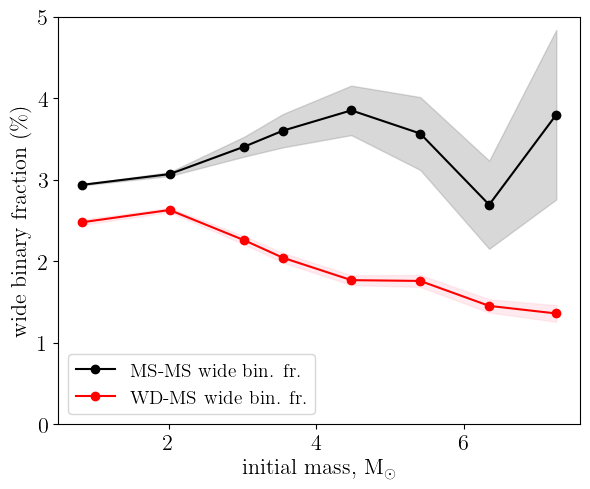

In [32]:
# OK, let's redo this with the full sample for MS-MS objects and with error bars
fig=plt.figure()
fig.patch.set_facecolor('white')
msms, msms_red, msms_bright, msms_single, msms_other = np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1., np.zeros(len(ms_bins))-1.
for i,mass in enumerate(ms_bins):
    # MS-MS wide-binary fraction: only mybin0 and full_msms matter
    # numerator
    ind1a=((full_msms['sma']>awide) & (full_msms['sma']<alimit) & (full_msms['m1']>=ms_bins_lo[i]) & (full_msms['m1']<ms_bins_hi[i]))
    ind1b=((full_msms['sma']>awide) & (full_msms['sma']<alimit) & (full_msms['m2']>=ms_bins_lo[i]) & (full_msms['m2']<ms_bins_hi[i]))
    msms[i]=len(full_msms[ind1a])+len(full_msms[ind1b])
    # now also add the red criterion on the MS companion:
    ind1c=(ind1a & (full_msms['m2']<m_red))
    ind1d=(ind1b & (full_msms['m1']<m_red))
    msms_red[i]=len(full_msms[ind1c])+len(full_msms[ind1d])
    # now also add the bright criterion on the MS companion:
    ind1e=(ind1c & (full_msms['m2']>m_bright))
    ind1f=(ind1d & (full_msms['m1']>m_bright))
    msms_bright[i]=len(full_msms[ind1e])+len(full_msms[ind1f])
    print('i, msms, msms_red, msms_bright: ', i, msms[i], msms_red[i], msms_bright[i])
    
    # denominator: all of the MS from WD-MS pairs count
    ind0=((mybin0['m2']>=ms_bins_lo[i]) & (mybin0['m2']<ms_bins_hi[i]))
    # effective singles have to be computed specially. Nothing comes from mybin2. 
    # Mybin0 is already fully taken into account at all separations. We need to consider full_msms, either close binaries
    # or those that are not in close binaries but are not in wide binaries either.
    # for close binaries, it's the more massive star 1 that should be in the mass range:
    eff1=((full_msms['sma']<aclose) & (full_msms['m1']>=ms_bins_lo[i]) & (full_msms['m1']<ms_bins_hi[i]))
    # for all other binaries: 
#    eff1a=((full_msms['sma']>aclose) & (full_msms['m1']>=ms_bins_lo[i]) & (full_msms['m1']<ms_bins_hi[i]))
#    eff1b=((full_msms['sma']>aclose) & (full_msms['m2']>=ms_bins_lo[i]) & (full_msms['m2']<ms_bins_hi[i]))
#    msms_other[i]=len(mybin0[ind0])+len(full_msms[eff1])+len(full_msms[eff1a])+len(full_msms[eff1b])
## We need to multiply mybin0 by 10 to account for the fact that we are using only the subsample here
    msms_other[i]=10*len(mybin0[ind0])+len(full_msms[eff1])
    
    # singles
    inds=((mysingles['m']>=ms_bins_lo[i]) & (mysingles['m']<ms_bins_hi[i]) & (mysingles['class']==0))
    msms_single[i]=len(mysingles[inds])
            
msms_fraction=msms/(msms+msms_other+best_norm*msms_single*10.)
msms_fraction_red=msms_red/(msms+msms_other+best_norm*msms_single*10.)
msms_fraction_bright=msms_bright/(msms+msms_other+best_norm*msms_single*10.)
msms_err=err_frac(msms,msms+msms_other,msms_single,best_norm*10)
msms_err_red=err_frac(msms_red,msms+msms_other,msms_single,best_norm*10)
msms_err_bright=err_frac(msms_bright,msms+msms_other,msms_single,best_norm*10)

plt.plot(ms_bins, msms_fraction_bright*100, color='black', marker='o', label='MS-MS wide bin. fr.')                                  
plt.fill_between(ms_bins,msms_fraction_bright*100-msms_err_bright*100,msms_fraction_bright*100+msms_err_bright*100, color='grey', alpha=0.3)
plt.plot(ms_bins, wdms['frac_bright']*100,color='red', marker='o', label='WD-MS wide bin. fr.')                                  
plt.fill_between(ms_bins,wdms['frac_bright']*100-wdms['err_bright']*100,wdms['frac_bright']*100+wdms['err_bright']*100, color='pink', alpha=0.3)
#plt.plot(ms_bins, wdwd['frac'],color='blue', marker='o', label='WD-WD wide bin. fr.')                                  
plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('wide binary fraction (\%)')
plt.ylim(0.,5.)
plt.legend(loc='lower left')
fig.tight_layout()
plt.savefig('public_stat_MSWD.png', dpi=300)
plt.show()

this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0


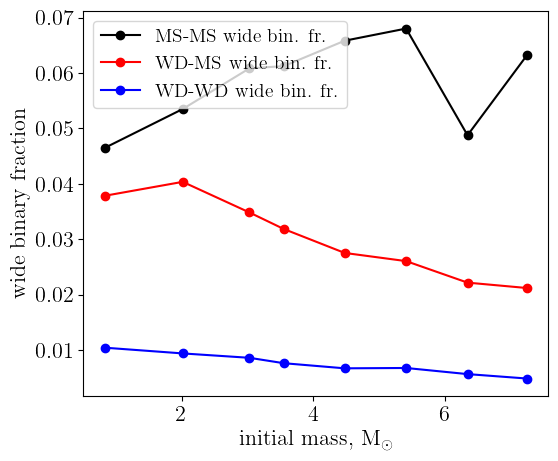

In [33]:
# this will be the number of stars in binaries, stars in binaries that became singles, and stars in singles 
# in each mass bin
# THIS SHOULD AGREE WITH THE PLOTS MADE WITHOUT ANY CUTS ON THE COMPANION (REDNESS, BRIGHTNESS)
num_bb=np.zeros(len(ms_bins))
num_bc=np.zeros(len(ms_bins))
num_bs=np.zeros(len(ms_bins))
num_s=np.zeros(len(ms_bins))
for i,cm in enumerate(ms_bins):
    # isolate all objects that are still binaries and where the mass is in the relevant regime and separation is in the relevant regime
    ind1=((full_binaries['m1']>=ms_bins_lo[i]) & (full_binaries['m1']<ms_bins_hi[i]) & (full_binaries['class']==1) & (full_binaries['sma']>awide) & (full_binaries['sma']<alimit))
    ind2=((full_binaries['m2']>=ms_bins_lo[i]) & (full_binaries['m2']<ms_bins_hi[i]) & (full_binaries['class']==1) & (full_binaries['sma']>awide) & (full_binaries['sma']<alimit))
    num_bb[i]=len(full_binaries[ind1])+len(full_binaries[ind2])
    # for the binaries contributing to singles, we are counting the surviving star not the dead star
    ind1=((full_binaries['m1']>=ms_bins_lo[i]) & (full_binaries['m1']<ms_bins_hi[i]) & (full_binaries['class']==0) & (full_binaries['death1']>present_day))
    print('this really should be 0:', len(full_binaries[ind1]))
    ind2=((full_binaries['m2']>=ms_bins_lo[i]) & (full_binaries['m2']<ms_bins_hi[i]) & (full_binaries['class']==0) & (full_binaries['death2']>present_day))
    num_bs[i]=len(full_binaries[ind1])+len(full_binaries[ind2])
    # for the close binaries contributing to singles, we are counting the more massive star
    ind1=((full_binaries['m1']>=ms_bins_lo[i]) & (full_binaries['m1']<ms_bins_hi[i]) & (full_binaries['class']==1) & (full_binaries['sma']<aclose))
    num_bc[i]=len(full_binaries[ind1])
    # and these are the original singles that are still on the MS: 
    ind=((mysingles['m']>=ms_bins_lo[i]) & (mysingles['m']<ms_bins_hi[i]) & (mysingles['class']==0))
    num_s[i]=len(mysingles[ind])
# observed binary fraction as a function of mass:
obs_fbinaries=num_bb/(best_norm*10*num_s+num_bb+num_bs+num_bc)

plt.figure()
plt.plot(ms_bins, obs_fbinaries, color='black', marker='o', label='MS-MS wide bin. fr.')                                  
plt.plot(ms_bins, wdms['frac'],color='red', marker='o', label='WD-MS wide bin. fr.')                                  
plt.plot(ms_bins, wdwd['frac'],color='blue', marker='o', label='WD-WD wide bin. fr.')                                  
plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('wide binary fraction')
plt.legend(loc='upper left')
plt.show()
# OK, without the alimit clause this looks identical to the plot in setup. With the alimit clause there are some
# shenanigans, but everything is in agreement now... 

In [34]:
print(ms_bins)
print(ms_bins_lo)
print(ms_bins_hi)

[0.82449322 2.01249995 3.02649613 3.55061953 4.47663543 5.41121495
 6.34579445 7.25586668]
[0.75479811 1.38749698 2.63704717 3.29418089 4.00933001 4.94392523
 5.87850467 6.81307255]
[1.38749698 2.63704717 3.29418089 4.00933001 4.94392523 5.87850467
 6.81307255 7.53975113]


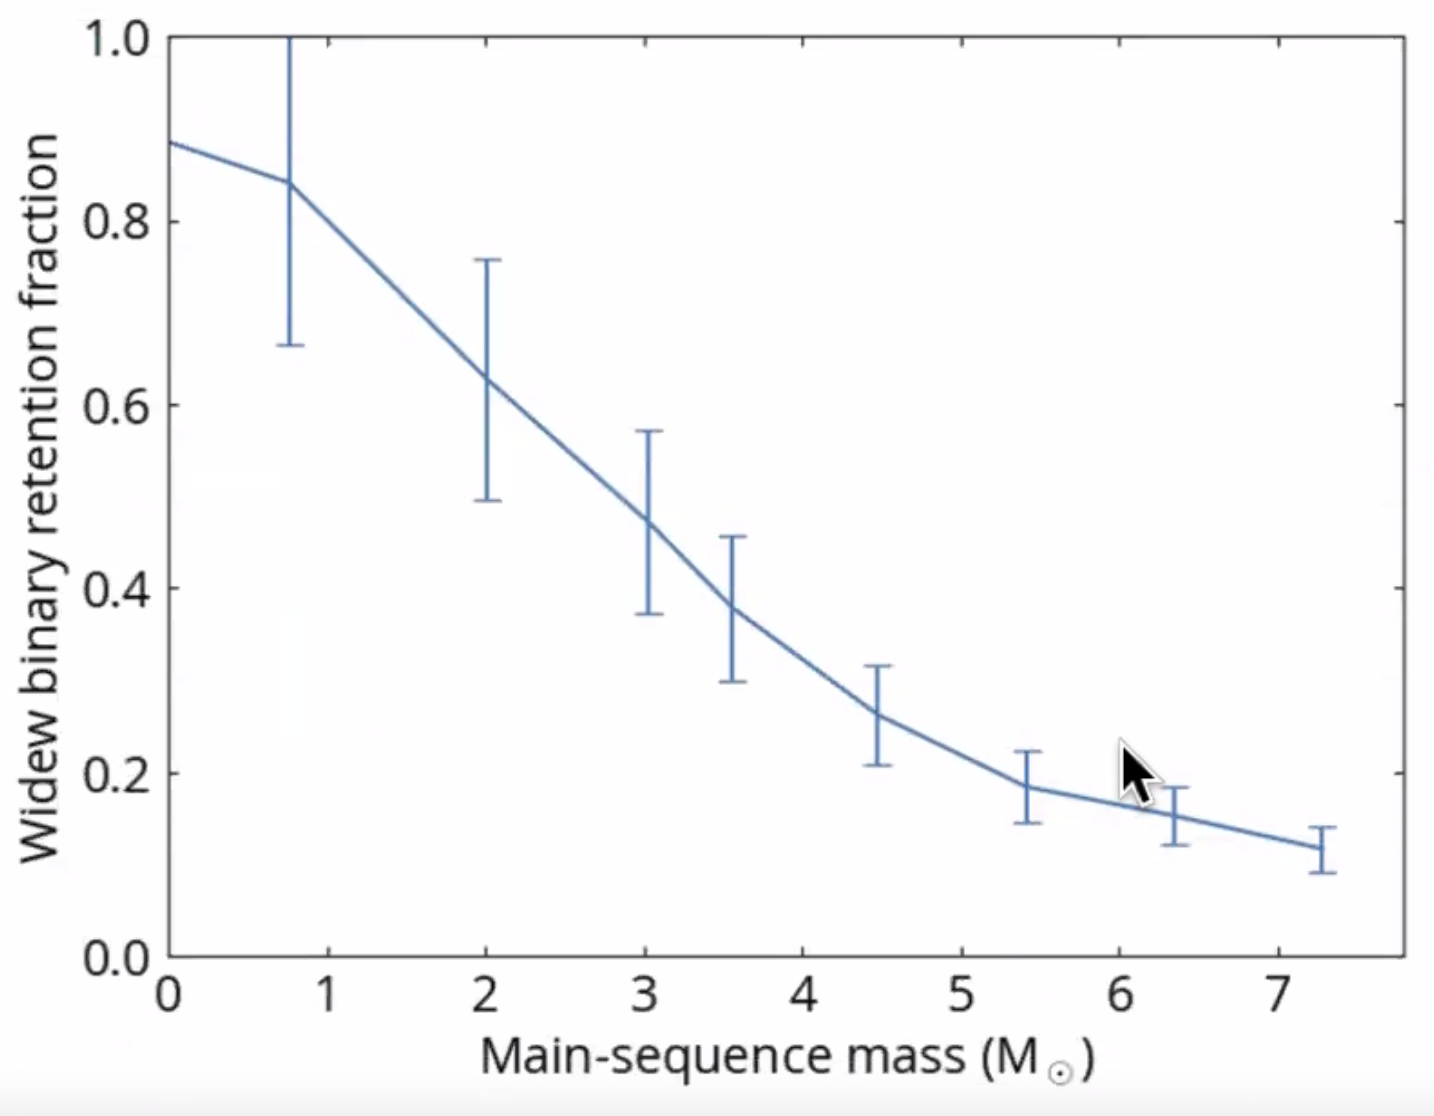

In [35]:
Image(filename='hchwang_july_17_retention.png', width=500)


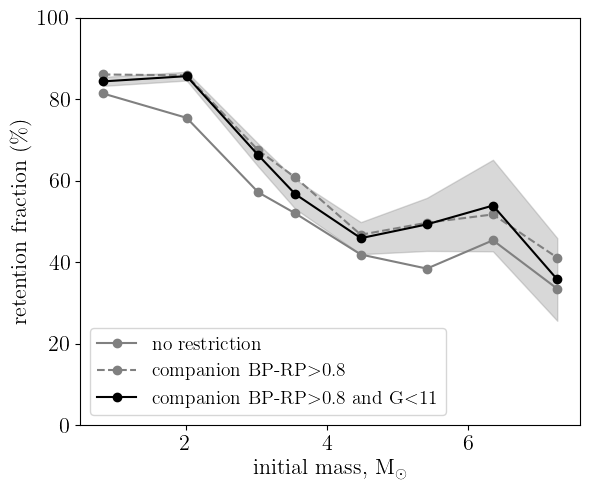

In [36]:
fig=plt.figure()
fig.patch.set_facecolor('white')
retention=wdms['frac_bright']*100/msms_fraction_bright
err_retention=retention*np.sqrt((wdms['err_bright']/wdms['frac_bright'])**2+(msms_err_bright/msms_fraction_bright)**2)
plt.fill_between(ms_bins,retention-err_retention,retention+err_retention, color='grey', alpha=0.3)

plt.plot(ms_bins,wdms['frac']*100/msms_fraction, color='grey', marker='o', label='no restriction')
plt.plot(ms_bins,wdms['frac_red']*100/msms_fraction_red, color='grey', linestyle='dashed', marker='o', label=r'companion BP-RP$>$0.8')
plt.plot(ms_bins,wdms['frac_bright']*100/msms_fraction_bright, color='black', marker='o', label=r'companion BP-RP$>$0.8 and G$<$11')

plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('retention fraction (\%)')
plt.legend(loc='lower left')
plt.ylim(0.,100.)
fig.tight_layout()
plt.savefig('public_stat_retention.png', dpi=300)
plt.show()

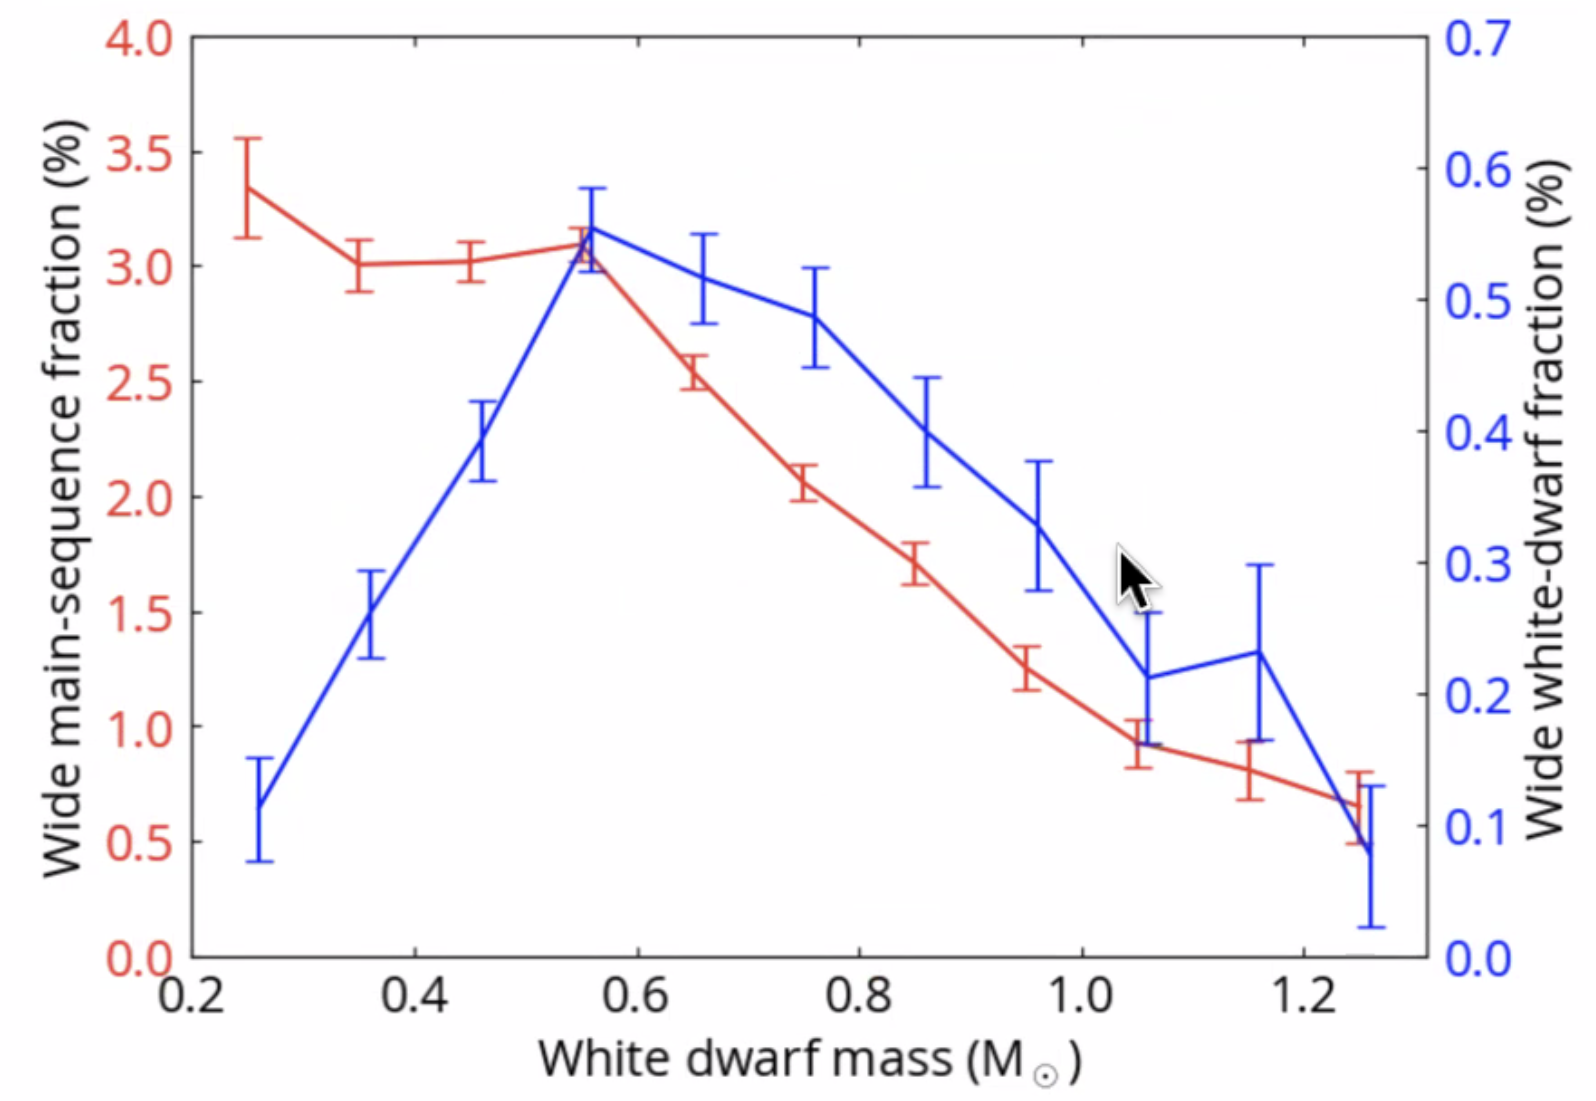

In [37]:
Image(filename='hchwang_july_9_WDMS_WDWD.png', width=500)


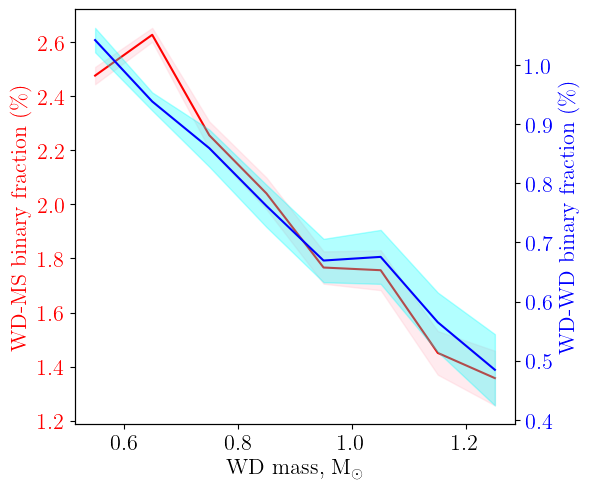

In [38]:
fig, ax1 = plt.subplots()
fig.patch.set_facecolor('white')

ax1.set_xlabel(r'WD mass, M$_{\odot}$')
ax1.set_ylabel(r'WD-MS binary fraction (\%)', color='red')
ax1.plot(wd_bins, wdms['frac_bright']*100, color='red')
ax1.fill_between(wd_bins,wdms['frac_bright']*100-wdms['err_bright']*100,wdms['frac_bright']*100+wdms['err_bright']*100, color='pink', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.set_ylabel(r'WD-WD binary fraction (\%)', color='blue')  # we already handled the x-label with ax1
ax2.plot(wd_bins, wdwd['frac']*100, color='blue')
ax2.fill_between(wd_bins,wdwd['frac']*100-wdwd['err']*100,wdwd['frac']*100+wdwd['err']*100, color='cyan', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('public_stat_wdms_wdwd.png', dpi=300)
plt.show()